# Unsupervised Learning - K-means Clustering on Bank Marketing Dataset 


Team members:
- Sophia Gabriela Martinez Albarran A01424430
- Eduardo Botello Casey A01659281
- Marcos Saade Romano A01784220

## Introduction 

This project applies unsupervised learning techniques to the Bank Marketing dataset obtained from the UCI Machine Learning Repository. The primary objective is to group customers into distinct segments using K-Means clustering, interpret the resulting groups, and evaluate the model using decision trees.

## Dataset description

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). It contains 6 integers variables and 11 categorical variables. It has 45211 instances of data, where we will be performing a cleaning and preprocessing before creating the models.

In [1]:
import sklearn 
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
  
# https://archive.ics.uci.edu/dataset/222/bank+marketing  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# Drop the column duration because in the page it says it isn't necessary for a predictive model
X = X.drop(columns=['duration'])

In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  campaign     45211 non-null  int64 
 12  pdays        45211 non-null  int64 
 13  previous     45211 non-null  int64 
 14  poutcome     8252 non-null   object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


In [3]:
X.describe()

,age,balance,day_of_week,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


## Data preprocessing 

- **Dataset source**: [UCI Repository - Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
- **Dropped Column**: duration was removed, as specified in the dataset documentation, since it is not suitable for predictive modeling.
- **Missing values**: 
    - job, education, and contact filled with 'unknown'.
    - poutcome filled with 'nonexistent'.

- **Encoding**:
    - Categorical variables were encoded using OneHotEncoder.
    - Numerical features were concatenated with encoded features to form the final input matrix X_final.


In [4]:
X.job = X.job.fillna('unknown')
X.education = X.education.fillna('unknown')
X.poutcome = X.poutcome.fillna('nonexistent')
X.contact = X.contact.fillna('unknown')

In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object']))
X_encoded_df = pd.DataFrame(
    X_encoded.toarray(), 
    columns=encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)
)


In [6]:
X_numerico = X.select_dtypes(exclude=['object'])
X_final = pd.concat([X_numerico.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Clustering Algorithm 

### Model Used 

- **Algorithm**: KMeans
- **Range of K**: 2 to 10
- **Initialization**: 10 (n_init=10)
- **Random State**: 42 (for reproducibility)

In [7]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_final)
                for k in range(2, 10)]

### Inertia Analysis 

Inertia measures the within-cluster sum of squared distances — in other words, how internally cohesive the clusters are. Lower inertia indicates that points are closer to their respective centroids, implying tighter clusters.

Using the following code, inertia values were calculated for K ranging from 2 to 10:


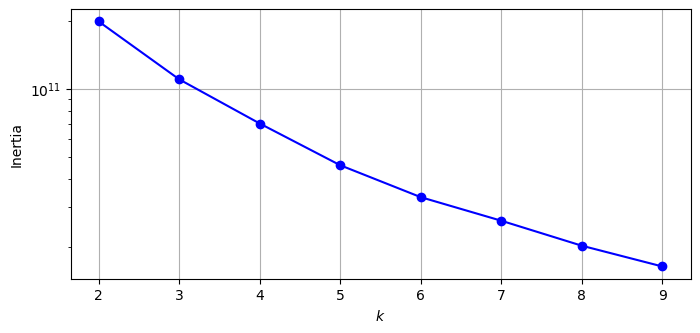

In [8]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.yscale('log')
plt.grid()

plt.show()

The resulting plot shows a sharp drop in inertia between K=2 and K=3, followed by a smoother and more gradual decrease from K=3 onward.

The “elbow” point—where the rate of decrease in inertia slows significantly—is observed at K=2.

After K=2, the marginal gain in reducing inertia diminishes, suggesting that adding more clusters does not lead to proportionally tighter groups.

The use of a logarithmic scale highlights the relative reduction, and helps confirm that K=2 offers the best trade-off between simplicity and cluster cohesion.

Thus, from an inertia-based perspective, K=2 is justified as the optimal number of clusters.



### Silhouette Analysis 

To evaluate the compactness and separation of the clusters, we used the Silhouette Coefficient, which ranges from -1 (poor clustering) to +1 (ideal clustering). The average silhouette score was computed for values of K ranging from 2 to 8 using the formula:

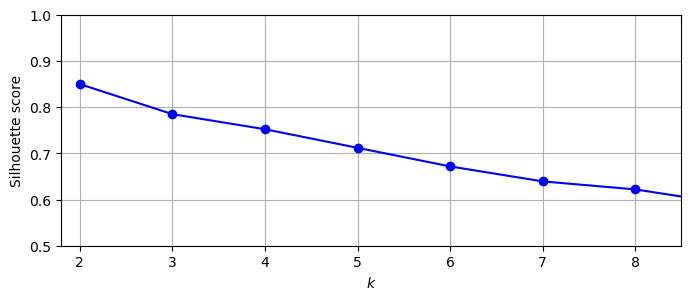

In [9]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_final, model.labels_)
                     for model in kmeans_per_k[0:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.5, 1])

plt.grid()
#save_fig("silhouette_score_vs_k_plot")
plt.show()

The graph shows a monotonic decrease in silhouette score as K increases, indicating that adding more clusters reduces the average cohesion of points within clusters.

K=2 results in the highest silhouette score (~0.85), which strongly suggests that the data naturally forms two well-separated groups.

The decline in score after K=2 shows that additional clusters start to split well-defined groups into smaller, less meaningful segments.

For example, at K=3 or K=4, although the inertia continues to decrease, the silhouette score drops, meaning the quality of clustering deteriorates.

Based on this analysis, we chose K=2 as the optimal number of clusters, prioritizing cluster quality over granularity.


### Silhouette (Per Cluster)

In addition to computing the average silhouette scores, we generated individual silhouette coefficient plots for different values of 
𝑘
k (2 to 5). These plots provide insight into:

The shape and size of each cluster.

How compact and well-separated each cluster is.

Each horizontal bar in the plots represents an individual point, and its length corresponds to the silhouette coefficient. A longer bar implies a better fit within its assigned cluster.



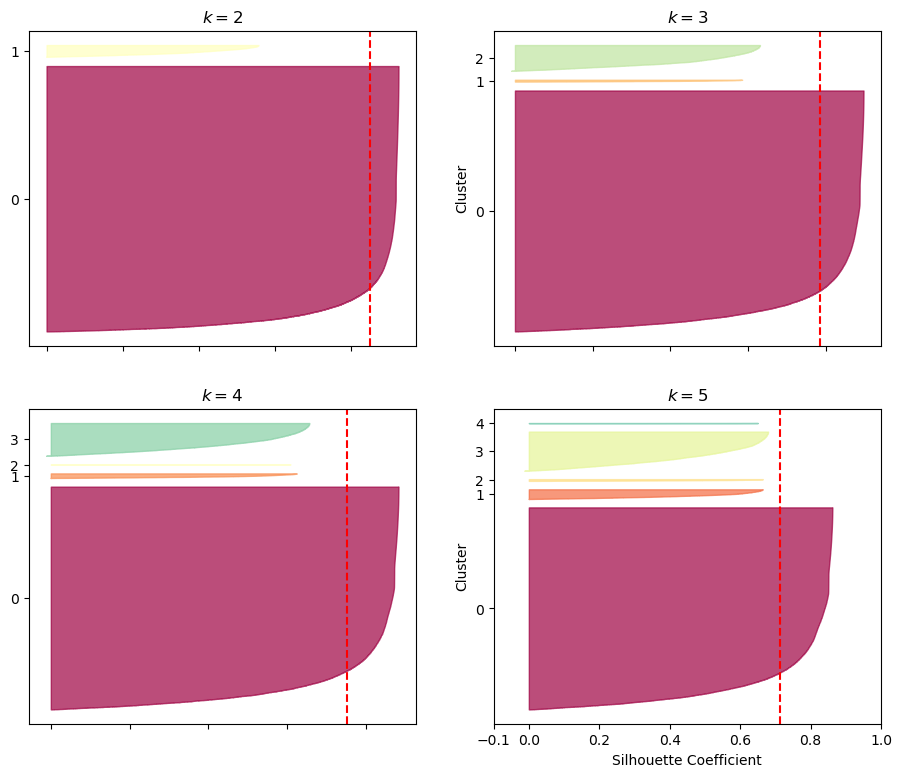

In [10]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_final, y_pred)

    padding = len(X_final) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

# save_fig("silhouette_analysis_plot")
plt.show()

**Observations**

K = 2:

The silhouette coefficients are relatively long and consistent across both clusters.

Most values are above 0.6, with a clean right-aligned shape.

This indicates very strong intra-cluster cohesion and separation from the other group.

K = 3 and K = 4:

Some clusters begin to show flattened or uneven shapes, especially clusters with fewer members.

The average silhouette score decreases slightly.

It suggests that some points are starting to fall closer to decision boundaries.

K = 5:

The silhouette widths are shorter and more dispersed across clusters.

One or two clusters have many low or borderline coefficients, which may indicate that these points are poorly clustered or ambiguous.


From this visual analysis, K = 2 again stands out as the configuration with the cleanest and most balanced cluster shapes. The individual cluster structure is tight and distinguishable, confirming the result obtained through the average silhouette score.



### Justification for K

Based on both the inertia and silhouette analyses, we selected **K=2** as the optimal number of clusters. While higher values of K slightly reduce inertia, the silhouette score decreases consistently as K increases. With K=2, the silhouette score is the highest (around 0.85), indicating well-defined and separated clusters. Additionally, the silhouette plot for K=2 shows clean and consistent shapes for both groups, supporting a good clustering structure.

# Decision Tree Classifier Evaluation 

To evaluate how well the KMeans-generated clusters are distinguishable in feature space, we trained a Decision Tree Classifier using the cluster labels as targets.

- Train/Test Split: 80% training, 20% testing

- Target: Cluster labels from KMeans (K=2)



In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y = kmeans_per_k[0].labels_

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10, min_samples_leaf=5)
dt_classifier.fit(X_train, y_train)


y_pred = dt_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Decision Tree Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8668
           1       1.00      1.00      1.00       375

    accuracy                           1.00      9043
   macro avg       1.00      1.00      1.00      9043
weighted avg       1.00      1.00      1.00      9043

Confusion Matrix:
[[8668    0]
 [   0  375]]


The decision tree classifier was able to perfectly separate the two clusters generated by KMeans, achieving:

- 100% accuracy

- No false positives or false negatives

- Identical precision, recall, and F1-score across both classes

This result confirms that the clusters found are very well-defined and linearly separable, which reinforces the validity of choosing K=2. Additionally, the decision tree provides interpretability into which features contribute most to this separation — a useful aspect in real-world marketing applications.

# Decision tree Structure

To interpret the logic behind the decision tree classifier used to separate the clusters, the model was exported and visualized using graphviz. The tree structure helps reveal the most influential features for determining cluster membership.



In [12]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:

from sklearn.tree import export_graphviz

export_graphviz(
        dt_classifier,
        out_file=str(IMAGES_PATH / "cluster_tree.dot"),  # path differs in the book
        feature_names=X_final.columns.tolist(),
        class_names=[str(cls) for cls in dt_classifier.classes_],
        rounded=True,
        filled=True
)

In [18]:

from graphviz import Source

Source.from_file(IMAGES_PATH / "cluster_tree.dot")  # path differs in the book

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

The root node splits on the feature:

balance <= 6375.0

This single feature alone perfectly separates the dataset into the two clusters:

- If a customer’s balance is less than or equal to €6375, they belong to Cluster 0.

- Otherwise, they are placed in Cluster 1.

The Gini impurity at the root node is very low (0.082), indicating a strong purity in the split.

The resulting leaves have Gini = 0.0, meaning they are perfectly homogeneous:

- One leaf contains 34,622 customers (class 0).

- The other contains 1,546 customers (class 1).

This confirms that balance is the most decisive feature in distinguishing the two clusters.

# Descriptive Stadistics 

After assigning each customer to a cluster, we explored the statistical properties of each group by examining key features such as age, balance, campaign contacts, and previous campaign outcomes.

In [15]:

full_df = pd.concat([X, pd.Series(y, name='cluster')], axis=1)
df_cluster_0 = full_df[full_df['cluster'] == 0]
df_cluster_1 = full_df[full_df['cluster'] == 1]

##### Cluster 0 (mayority group)

In [16]:

df_cluster_0.describe()

,age,balance,day_of_week,campaign,pdays,previous,cluster
count,43290.000000,43290.000000,43290.000000,43290.000000,43290.00000,43290.000000,43290.0
mean,40.813929,896.677108,15.793809,2.767822,40.23167,0.576253,0.0
std,10.561367,1295.762132,8.342228,3.093884,100.45451,2.305106,0.0
min,18.000000,-8019.000000,1.000000,1.000000,-1.00000,0.000000,0.0
25%,33.000000,61.000000,8.000000,1.000000,-1.00000,0.000000,0.0
50%,39.000000,404.500000,16.000000,2.000000,-1.00000,0.000000,0.0
75%,48.000000,1230.000000,21.000000,3.000000,-1.00000,0.000000,0.0
max,95.000000,6374.000000,31.000000,58.000000,871.00000,275.000000,0.0



- Size: 43,290 customers

- Average balance: €896

- Average age: ~40.8 years

- Previous contacts: 0.57 (on average)

- Balance range: From -8019 to €6374

- Most values in pdays = -1, suggesting no recent contact in previous campaigns.

This cluster contains customers with lower financial engagement, fewer prior contacts, and more modest account balances. The majority of the bank’s client base falls into this group.

##### Cluster 1 ( High-Value Segment)

In [ ]:

df_cluster_1.describe()

,age,balance,day_of_week,campaign,pdays,previous,cluster
count,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.0
mean,43.691827,11854.518480,16.090578,2.674128,39.435190,0.672046,1.0
std,11.501756,8087.401557,7.860908,3.189338,92.504809,2.264236,0.0
min,20.000000,6376.000000,1.000000,1.000000,-1.000000,0.000000,1.0
25%,34.000000,7529.000000,9.000000,1.000000,-1.000000,0.000000,1.0
50%,42.000000,9173.000000,18.000000,2.000000,-1.000000,0.000000,1.0
75%,53.000000,12939.000000,21.000000,3.000000,-1.000000,0.000000,1.0
max,87.000000,102127.000000,31.000000,63.000000,779.000000,35.000000,1.0


- Size: 1,921 customers

- Average balance: €11,854 (more than 13x higher than Cluster 0)

- Average age: ~43.7 years (slightly older)

- Balance range: €6,376 to €102,127

- Previous contacts: slightly higher (0.67), indicating better engagement history.

This cluster clearly identifies premium clients: those with significantly higher savings, older average age, and possibly higher campaign responsiveness. These clients could be targeted for investment services or tailored offerings.

The differences in balance and age between clusters are substantial. Cluster 1 is notably wealthier and slightly older. Combined with the earlier decision tree results (which split perfectly based on balance), this confirms a strong natural segmentation between general clients and high-value clients.

These insights are key for strategic marketing, allowing the bank to deliver more personalized communications or financial products to each segment.

# Conclusion 

The unsupervised analysis using K-Means clustering revealed two well-defined groups within the Bank Marketing dataset. These clusters showed clear differences in both financial and demographic variables.

- **Cluster 0** represents the majority of the clients. It includes 43,290 individuals with a relatively low average balance (≈ €896), a younger average age (~40.8 years), and nearly no previous campaign contact history. Most clients in this group had limited financial engagement, and their pdays values indicate that they were not recently contacted.

- **Cluster 1** is much smaller, with 1,921 individuals, but significantly different in profile. Customers in this group have a much higher average balance (≈ €11,854), are slightly older (~43.7 years), and display more financial activity. Their minimum balance starts where the previous cluster ends (~€6,376), confirming the natural separation identified by the model.

The silhouette analysis showed that **K=2 offered the best balance between compactness and separation**, while the silhouette coefficient plots confirmed a clean clustering structure, especially for Cluster 0.

Finally, a decision tree classifier trained to predict the cluster labels achieved **perfect classification** (accuracy = 1.00), with balance being the single most informative variable for separating both groups.

These results confirm that the dataset contains **naturally occurring, clearly separable groups**, and that financial behavior especially account balance is a central factor in differentiating them.

